In [1]:
import pandas as pd
import ast

In [19]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.metrics.pairwise import cosine_similarity

def get_cluster_representatives(embeddings, words, cluster_labels, cluster_id, n=20):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_embeddings = embeddings[cluster_indices]
    
    centroid = np.mean(cluster_embeddings, axis=0)
    similarities = cosine_similarity(cluster_embeddings, centroid.reshape(1, -1)).flatten()
    
    top_indices = np.argsort(similarities)[-n:][::-1]
    return [words[cluster_indices[i]] for i in top_indices]

def cluster_and_visualize(keyword_embeddings):
    embeddings_array = np.array(list(keyword_embeddings.values()))
    words = list(keyword_embeddings.keys())
    
    inertias = []
    k_range = range(1, min(20, len(embeddings_array)))
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings_array)
        inertias.append(kmeans.inertia_)
    
    kneedle = KneeLocator(k_range, inertias, curve='convex', direction='decreasing', S=1.0)
    optimal_k = kneedle.elbow
    
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(embeddings_array)
    
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings_array)
    
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='tab10', alpha=0.6)
    
    plt.legend(*scatter.legend_elements(),
                        title="Clusters",
                        loc="center left",
                        bbox_to_anchor=(1, 0.5))
    
    # Add 3 random labels for each cluster
    for cluster_id in range(optimal_k):
        cluster_mask = clusters == cluster_id
        cluster_points = embeddings_2d[cluster_mask]
        cluster_words = np.array(words)[cluster_mask]
        
        if len(cluster_points) > 0:
            n_samples = min(3, len(cluster_points))
            random_indices = np.random.choice(len(cluster_points), n_samples, replace=False)
            
            for idx in random_indices:
                plt.annotate(cluster_words[idx][:50] + '...' if len(cluster_words[idx]) > 50 else cluster_words[idx], 
                           (cluster_points[idx, 0], cluster_points[idx, 1]),
                           fontsize=8)
    
    plt.title(f'Keyword Clusters (k={optimal_k})')
    plt.show()
    
    # Print representatives for each cluster
    print("\nTop 10 representatives for each cluster:")
    for cluster_id in range(optimal_k):
        representatives = get_cluster_representatives(embeddings_array, words, clusters, cluster_id)
        print(f"\nCluster {cluster_id}:")
        print("- "+"\n- ".join(representatives))
    
    return clusters, optimal_k

In [6]:
# statements
x = pd.read_csv('result/embedding-triplets-keys.csv')
x['0'] = x['0'].apply(lambda x: ast.literal_eval(x))

xm = {}
for i in range(len(x)):
    r = x.iloc[i]
    xm[r[0]] = r[1]

/var/folders/bw/64y3yr9n6v50fgm86wtx236c0000gn/T/ipykernel_12348/2791862810.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xm[r[0]] = r[1]


In [12]:
m = pd.read_csv('result/merged-triplets-keys.csv')

embedding = {}
for i in set(m['representative'].unique()):
    embedding[i] = xm[i]

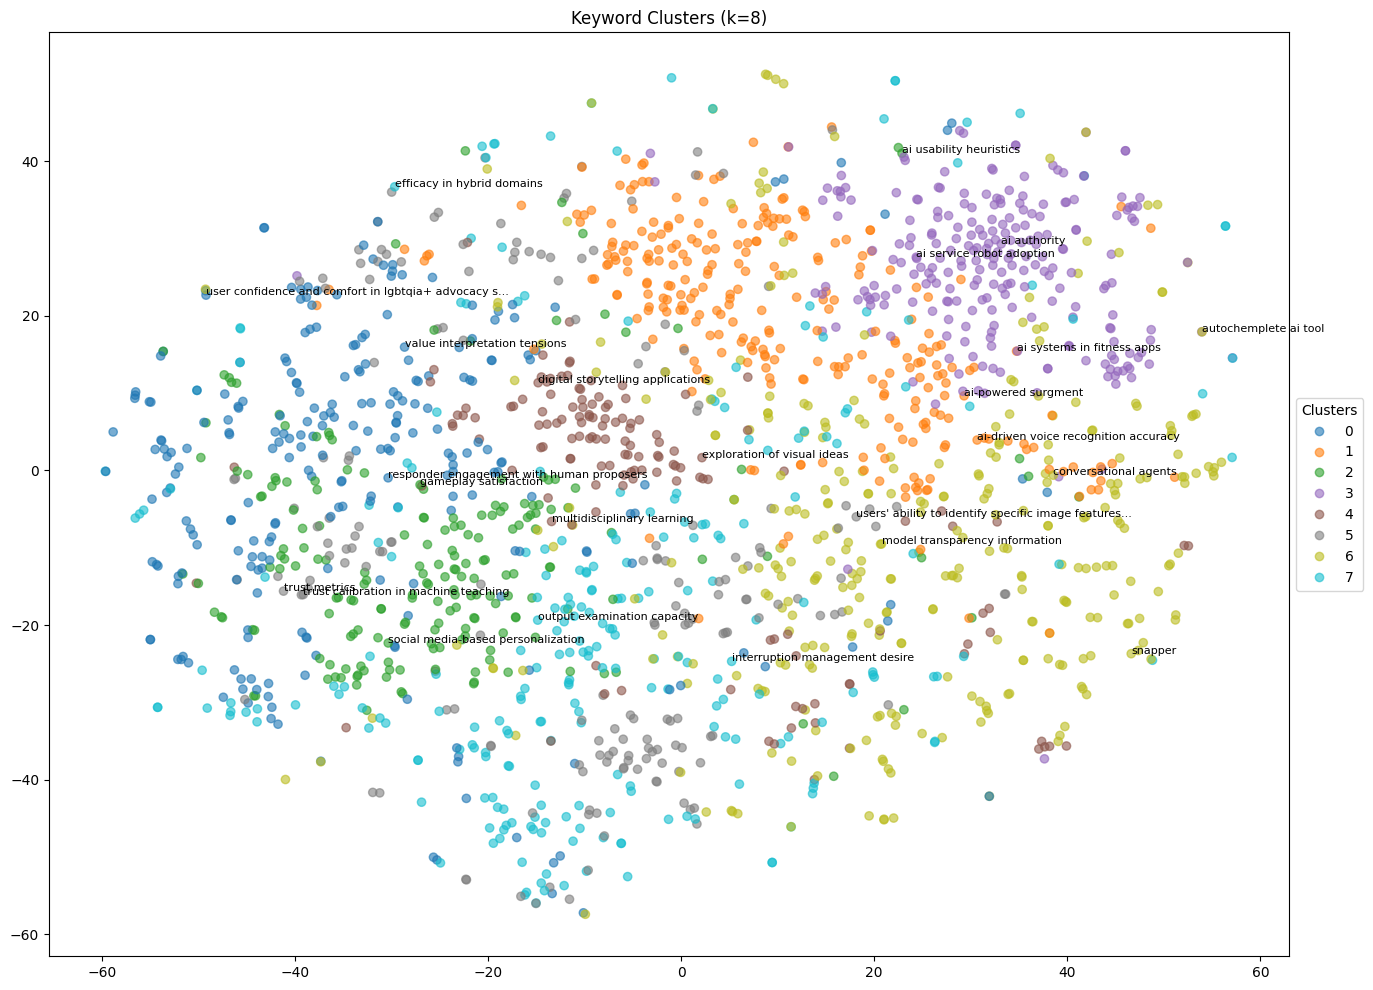


Top 10 representatives for each cluster:

Cluster 0:
- participant perceptions
- community perceptions
- participants' views
- participants' decision-making
- user trust perceptions
- user perceptions of ability and benevolence
- participants' attitudes
- perceived ethical considerations
- perceived warmth and collaboration
- implicit user bias awareness
- group perceptions
- fairness perceptions
- stakeholders' perspectives on fairness
- perceived collaboration and quality
- participants' feelings of agency
- interaction experiences
- individual decision-making in collaborative contexts
- worker appropriateness perception
- trust, likeability, and perceived safety in mental health applications
- perceived trustworthiness and authenticity

Cluster 1:
- ai-based tools
- ai-based platforms
- effectiveness of ai assistance
- human-ai interaction
- interactive ai explanations
- ai-powered automation
- user understanding of the ai system
- users' perception of ai performance
- human-like a

In [20]:
clusters, k = cluster_and_visualize(embedding)

In [23]:
pd.DataFrame([*zip(embedding.keys(), clusters.tolist())]).to_csv("result/clustered-triplets-keys.csv", index=False)